In [ ]:
""" ▶ tf.keras.applications.vgg16 """
'''
tf.keras.applications 에 포함된 모델들은 사전에 학습된(pre-trained) 가중치를 가진 유명한 딥러닝 모델의 구현체다.
VGG, ResNet, Inception, MobileNet 등의 다양한 유명한 아키텍처를 제공하며, 이들 모델은 대규모 이미지 데이터셋(주로 ImageNet)에서 미리 학습되었다.
모델을 로드할 때 weights 파라미터를 'imagenet'으로 설정하면 사전에 학습된 가중치를 사용하여 모델을 로드할 수 있다. 가중치를 로드하지 않으려면 weights=None으로 설정하면 된다.

'''

![](etc/vgg16.png)
https://smuhabdullah.medium.com/understanding-vgg16-a-powerful-deep-learning-model-for-image-recognition-d40b074fd01c

https://arxiv.org/pdf/1409.1556.pdf%20http://arxiv.org/abs/1409.1556.pdf  
- 13 Convolution Layers + 3 Fully-connected Layers (이래서 vgg 16 임)
- 3x3 convolution filters
- stride: 1 & padding: 1
- 2x2 max pooling (stride : 2)
- ReLU

========= 논문에 쓰인 최적화 알고리즘  
The batch size was set to 256,   
momentum to 0.9   
weight decay (the L2 penalty multiplier set to 5·10−4)   
dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).  
The learning rate was initially set to 10−2, and then decreased by a factor of 10 when the validation set accuracy stopped improving

========= 학습 이미지 크기  
To obtain the fixed-size 224×224 ConvNet input images,

========= Overfitting 방지  
데이터 수를 늘렸음, 변환 이미지 적용

Tip) CNN 구조 학습에서 학습대상인 가중치는 필터의 크기에 해당한다. 7x7 필터 1개에 대한 학습 파라미터 수는 49이고, 3x3 필터 3개에 대한 학습 파라미터 수는 27(3x3x3)이 된다.

In [1]:
""" ▶ Step 1. 학습된 모델인 VGG16 로드 """
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16

(x_train_origin, y_train), (x_test_origin, y_test) = cifar10.load_data()

x_origin_mean = np.mean(x_train_origin, axis=(0,1,2))
x_origin_std = np.std(x_train_origin, axis=(0,1,2))
print(x_origin_mean, x_origin_std)

x_train = (x_train_origin - x_origin_mean) / x_origin_std
x_test = (x_test_origin - x_origin_mean) / x_origin_std

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=777)

# y_train = np.squeeze(y_train)
# y_val = np.squeeze(y_val)

print(tf.keras.applications.vgg16.VGG16 is tf.keras.applications.VGG16) # 뭐지 둘다 같네


[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
True


In [2]:
""" ▶ Step 2. 데이터 늘리기 """

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size = batch_size)

val_generator = val_datagen.flow(x_val, y_val,
                                batch_size = batch_size)

In [3]:
""" ▶ Step 3. 모델 구성하기 """

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', input_shape=(32, 32, 3), include_top=False)
vgg16.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [4]:
# 레이어 동결
for layer in vgg16.layers[:-4]:
    layer.trainable = False
    
vgg16.summary()  # Non-trainable params 가 0 에서  7,635,264 로 증가한걸 볼 수 있다.

# vgg16 모델에 기반하여, 분류기는 직접 정의한다.
model = Sequential([
    vgg16,
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax'),
])

model.compile(optimizer = Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [5]:
""" ▶ Step 4. 모델 학습하기 """

def get_step(train_len, batch_size):
    if (train_len % batch_size) > 0:
        return train_len // batch_size + 1
    else:
        return train_len // batch_size
    
hist = model.fit(train_generator, epochs = 17,
                 steps_per_epoch = get_step(len(x_train), batch_size),
                 validation_data = val_generator,
                 validation_steps = get_step(len(x_val), batch_size))

Epoch 1/17


1094/1094 [==============================] - 448s 408ms/step - loss: 1.1183 - acc: 0.1022 - val_loss: 1.0628 - val_acc: 0.1609
Epoch 2/17
1094/1094 [==============================] - 441s 403ms/step - loss: 0.9155 - acc: 0.1023 - val_loss: 0.7956 - val_acc: 0.0747
Epoch 3/17
1094/1094 [==============================] - 438s 401ms/step - loss: 0.8545 - acc: 0.1035 - val_loss: 0.8570 - val_acc: 0.0743
Epoch 4/17
1094/1094 [==============================] - 444s 406ms/step - loss: 0.7998 - acc: 0.1031 - val_loss: 0.7453 - val_acc: 0.0906
Epoch 5/17
1094/1094 [==============================] - 443s 405ms/step - loss: 0.7662 - acc: 0.1026 - val_loss: 0.7256 - val_acc: 0.0983
Epoch 6/17
1094/1094 [==============================] - 464s 424ms/step - loss: 0.7360 - acc: 0.1036 - val_loss: 0.7182 - val_acc: 0.1081
Epoch 7/17
1094/1094 [==============================] - 454s 415ms/step - loss: 0.7017 - acc: 0.1029 - val_loss: 0.7013 - val_acc: 0.0970
Epoch 8/17
1094/1094 [==========

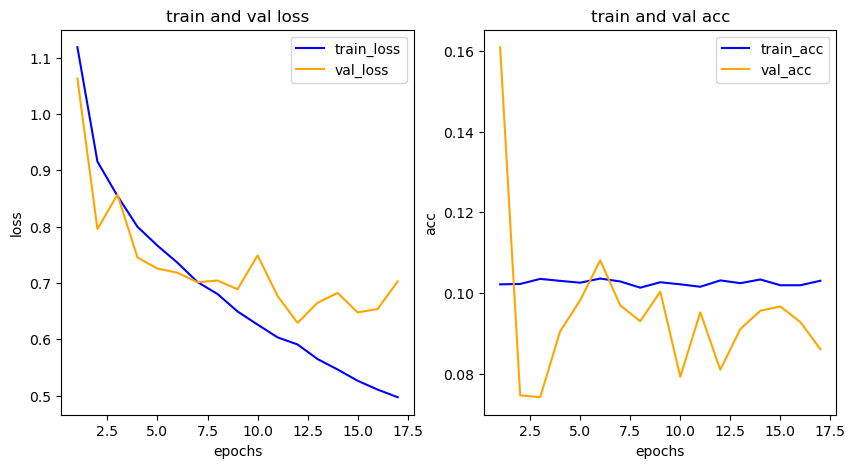

In [6]:
""" ▶ Step 5. 확인 및 평가 """

import matplotlib.pyplot as plt

hist_dict = hist.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [7]:
#6-1 
import tensorflow as tf

get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]
print('층 이름: ', get_layer_name)
print('출력 층 이름: ', get_layer_name)

층 이름:  ['vgg16', 'flatten', 'dense', 'batch_normalization', 'activation', 'dense_1']
출력 층 이름:  ['vgg16', 'flatten', 'dense', 'batch_normalization', 'activation', 'dense_1']


In [8]:
#6-2
# 모델 전체에서 output을 가져올 수 있습니다.
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output)

# 테스트셋의 두 번째 데이터는 '배'입니다.
test_img = np.expand_dims(x_test[1], axis = 0) #  expand_dims는 axis로 지정된 차원을 추가
feature_maps = visual_model.predict(test_img)

for layer_name, feature_map in zip(get_layer_name, feature_maps):
    # Dense 층은 제외합니다.
    if(len(feature_map.shape) == 4):
        img_size = feature_map.shape[1]
        features = feature_map.shape[-1]
        
        # (img_size, img_size)의 feature_map이 features 개수만큼 존재합니다.
        display_grid = np.zeros((img_size, img_size * features))
        
       #각 특징맵을 display_grid 배열에 이어 붙입니다. 
        for i in range(features):
            x = feature_map[0, :, :, i]
            x -= x.mean(); x /= x.std()
            x *= 64; x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * img_size : (i + 1) * img_size] = x
            
        plt.figure(figsize = (features, 2 + 1./features))
        plt.title(layer_name, fontsize = 20)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: []